In [7]:
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier   
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [8]:
df = pd.read_csv("K:/Computer Science/AIMLDL/Brand_Reputation_Management_System/sentiment_analysis/data_preprocessing/processed_dataset.csv")
df = df.dropna(subset=['cleaned_review', 'sentiment'])

X = df['cleaned_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
tfidf = TfidfVectorizer(max_features=5000, min_df=5)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

scaler = StandardScaler(with_mean=False)
X_train_tfidf = scaler.fit_transform(X_train_tfidf)
X_test_tfidf = scaler.transform(X_test_tfidf)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [10]:
X_train_tfidf.shape

(307463, 5000)

In [11]:
y_train_encoded.shape

(307463,)

In [12]:
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [13]:
models = {
    'XGBClassifier': XGBClassifier(learning_rate=0.2, max_depth=6, n_estimators=200, eval_metric='mlogloss'),
    'Logistic Regression': LogisticRegression(C=0.01, solver='liblinear'),
    'Naive Bayes': MultinomialNB(alpha=10.0),
    'SVM': SVC(kernel='linear', C=1.0),
    'Decision Tree': DecisionTreeClassifier(criterion='gini', max_depth=None),
    'Random Forest': RandomForestClassifier(max_depth=None, min_samples_split=5, n_estimators=200, n_jobs=-1)
}

In [ ]:
results = {}
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}:")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_tfidf, y_train_encoded, cv=5, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

    # Train and evaluate
    model.fit(X_train_tfidf, y_train_encoded)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    results[f"{model_name}"] = accuracy
    print(f"{model_name} Classification Report (TF-IDF):")
    print(classification_report(y_test_encoded, y_pred))

    # Confusion matrix
    cm_tfidf = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_encoded), yticklabels=np.unique(y_test_encoded))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


Evaluating XGBClassifier:



Overall Model Performance:
                          Model  Accuracy
2  Logistic Regression (TF-IDF)  0.879153
0        XGBClassifier (TF-IDF)  0.871126
7           Random Forest (BOW)  0.870827
1           XGBClassifier (BOW)  0.869279
6        Random Forest (TF-IDF)  0.869071
3     Logistic Regression (BOW)  0.867302
5             Naive Bayes (BOW)  0.839136
4          Naive Bayes (TF-IDF)  0.766685


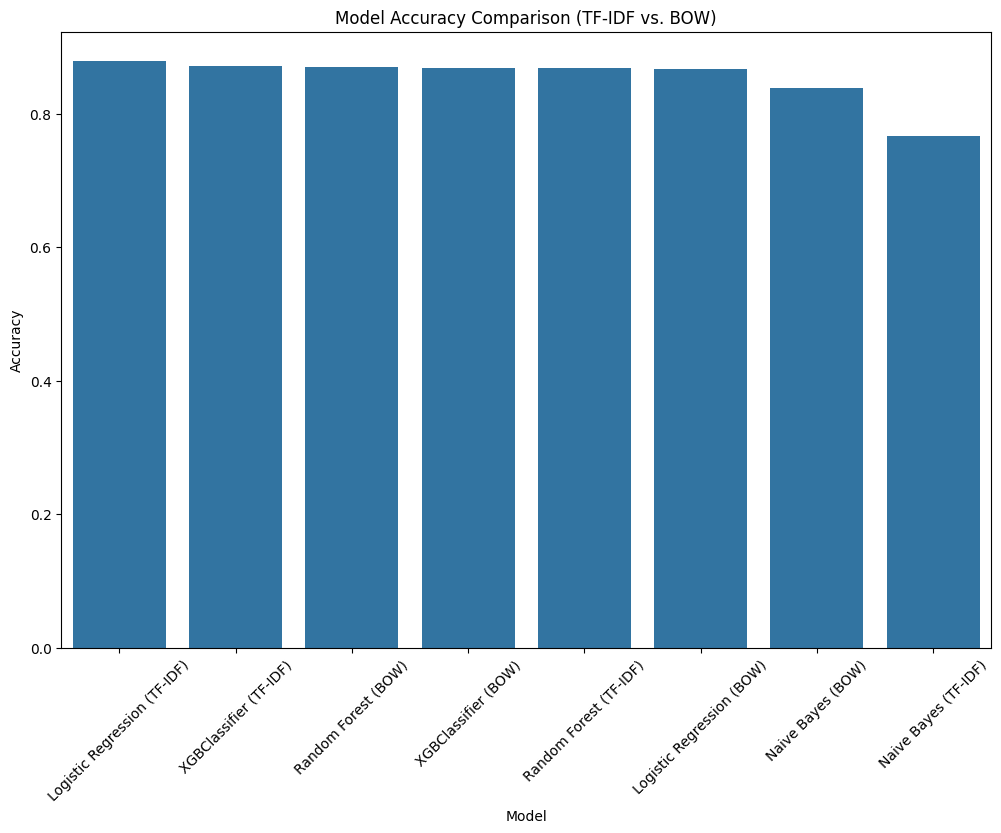

In [ ]:
results_df = pd.DataFrame([{"Model": name, "Accuracy": acc} for name, acc in results.items()])
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)

print("\nOverall Model Performance:")
print(results_df)
plt.figure(figsize=(12, 8))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()

In [ ]:
model_save_path = "K:/Computer Science/Brand_Reputation_Management_System/sentiment_analysis/saved_models/"
os.makedirs(model_save_path, exist_ok=True)

for model_name, model in models.items():
    model_filename = os.path.join(model_save_path, f"{model_name}.pkl")
    with open(model_filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"{model_name} saved to {model_filename}")

XGBClassifier saved to K:/Computer Science/Brand_Reputation_Management_System/sentiment_analysis/saved_models/XGBClassifier.pkl
Logistic Regression saved to K:/Computer Science/Brand_Reputation_Management_System/sentiment_analysis/saved_models/Logistic Regression.pkl
Naive Bayes saved to K:/Computer Science/Brand_Reputation_Management_System/sentiment_analysis/saved_models/Naive Bayes.pkl
Random Forest saved to K:/Computer Science/Brand_Reputation_Management_System/sentiment_analysis/saved_models/Random Forest.pkl
